# Kolokvij 1: priprema

Za potrebe ovog zadatka, potrebno je instalirati Google Tesseract OCR alat. 
 1. alat se nalazi u mapi na razdiobi i potrebno ga je instalirati, recimo u `D:\Tools\Tesseract-OCR`
 2. spremiti HR model OCR-a `hrv.traineddata` u mapu alata `D:\Tools\Tesseract-OCR\tessdata`
 

## Zadatak 1

U prilogu vam da je dana slika stranice VRH rječnika. Vaš je zadatak sljedeći:
  1. Napravite OCR prepoznavanje teksta na slici i pretvorite u tekstualnu datoteku
  2. Iz teksta izvući samo imenice sa opisom i gramatičkim obilježjima i spremiti u JSON datoteku prema sljedećem formatu
  
  
Npr. 

```json
iskopina.json
[
  {
    "rijec": "iskopina ",
    "vrsta": "im ",
    "obiljezja": [
      "iskopina",
      " G -e",
      " mn G -Ina"
    ],
    "definicija": "1. -* iskop "
  }
  ]
```




In [5]:
#!/opt/anaconda3/bin/pip install pytesseract
from PIL import Image
import pytesseract
# ako  Windows
# pytesseract.pytesseract.tesseract_cmd = 'C:\\Tools\\Tesseract-OCR\\tesseract.exe'


In [7]:
print(pytesseract.get_languages(config=''))

['equ', 'osd', 'eng', 'hrv']


In [11]:
ocr = pytesseract.image_to_string(Image.open('vrh.jpg'),lang='hrv')

In [13]:
print(ocr)

anerltropsiia i'm ž (aneritropsija; G é) PAT sljepoća za ere
venu boju, nesposobnost očiju da zamjećuju crvenu boju
© nim., ADI-, ERITRO-, -0PSUA

aneroid im m (aneroid; G aneroida; mn N ancrofdi, G ane-
roidá) MET barometar bez žive s elastičnim metalnim pei-i»
ma, točnost mu je manja od živinoga baron-letra [koristili
anemia'] © prema grč.

anestetičan rid (anestetičan, anestetična, anestčtično; G
-čna; odr -čni, G -čn6g(a)> koji prouzročuje anesteziju,
koji čini koga neosjetljivim na bol lanesreličnn sredstva]

anestetičar im m (anestetičar; G -a, V -e/-u; mn N -i, G -'Z\)
MED 1. medicinski tehničari medicinska sestra koji pomažu
tijekom anestezije; za svoj rad odgovaraju liječniku ane»
steziologu [kongres / udruženje anestetičaral 2. PREN onaj
koji djeluje poput anestezije [Anestetičari knj evnoxti, koji
od estetike prave palicu i od književnoga poprišta groblje
još prije boja.] © —> anestezija

anestetičarka im ž (anestetičárka; G —e, DL -i; mn G —á/-i)
MED ž moe par od anestetiča

In [96]:
import re
entries = re.split(r'\n\n',ocr)
regex_gram = '((\w+)\s+(im)\s+(m|ž|s)\s+(\(.*?\)))'
regex_def =  '.*?([A-Z]+?)(\w+)'
import json

for data in entries:
    lex = {}
    mObj = re.match(regex_gram,data,re.MULTILINE | re.DOTALL)
    if mObj:
        lex['riječ'], lex['tip'], lex['rod'], lex['gramatička obilježja'] =  mObj.group(2), mObj.group(3), mObj.group(4), mObj.group(5)        
        lex['definicija'] = data.partition(mObj.group(1))[2]
        
        jsonObj = json.dumps(lex)
        
        with open(f"{lex['riječ']}.json", "w") as outfile:
            outfile.write(jsonObj)
        
        
        
        
        
        
        



## Zadatak 2

U ovom zadatku potrebno je izgraditi n-gramski model za tekstove HR jezika koji su dani u prilogu. Tekstovi su dani u .txt formatu.

Učinite sljedeće:
  1. Izgradite skup za treniranje na kojem ćete naučiti model (80% rečenica korpusa). Evaluirajte model uz pomoć mjere perpleksnosti na skupu za testiranje (20%). Na tekstu primijenite neku od normalizacijskih  tehnika kako bi dobili što bolju perpleksnost. 
  2. Pored MLE procjenitelja, koristite barem metodu zaglađivanja i interpolacije. Odaberite onu metodu koja daje najbolju perpleksnost. 
  3. Generirajte nekoliko rečenica iz najboljeg modela



In [111]:
import io

with io.open('kafka-preobrazaj3.txt', encoding='utf8') as fin:
    text = fin.read()

In [112]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.util import bigrams, ngrams
from nltk.lm.models import MLE, Laplace
from sklearn.model_selection import train_test_split

In [121]:
# tokenizacija i normalizacija 
with open('hr_stopwords.txt') as f:
    stopWordsCro= f.read()

print(stopWordsCro)

'a', 'ako', 'ali', 'bi', 'bih', 'bila', 'bili', 'bilo', 'bio', 'bismo', 'biste', 'biti', 'bumo', 'da', 'do', 'duž', 'ga', 'hoće', 'hoćemo', 'hoćete', 'hoćeš', 'hoću', 'i', 'iako', 'ih', 'ili', 'iz', 'ja', 'je', 'jedna', 'jedne', 'jedno', 'jer', 'jesam', 'jesi', 'jesmo', 'jest', 'jeste', 'jesu', 'jim', 'joj', 'još', 'ju', 'kada', 'kako', 'kao', 'koja', 'koje', 'koji', 'kojima', 'koju', 'kroz', 'li', 'me', 'mene', 'meni', 'mi', 'mimo', 'moj', 'moja', 'moje', 'mu', 'na', 'nad', 'nakon', 'nam', 'nama', 'nas', 'naš', 'naša', 'naše', 'našeg', 'ne', 'nego', 'neka', 'neki', 'nekog', 'neku', 'nema', 'netko', 'neće', 'nećemo', 'nećete', 'nećeš', 'neću', 'nešto', 'ni', 'nije', 'nikoga', 'nikoje', 'nikoju', 'nisam', 'nisi', 'nismo', 'niste', 'nisu', 'njega', 'njegov', 'njegova', 'njegovo', 'njemu', 'njezin', 'njezina', 'njezino', 'njih', 'njihov', 'njihova', 'njihovo', 'njim', 'njima', 'njoj', 'nju', 'no', 'o', 'od', 'odmah', 'on', 'ona', 'oni', 'ono', 'ova', 'pa', 'pak', 'po', 'pod', 'pored', 'pr

In [99]:
preprocess_text = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(text)]
tokenized_text = []

for i in preprocess_text:
    tokenized_text.append([w for w in i if not w in stopWordsCro])
tokenized_text[0]

['franz',
 'kafka',
 'preobražaj',
 's',
 'njemačkog',
 'preveo',
 'zlatko',
 'gorjan',
 'projekt',
 'je',
 'sufinancirala',
 'europska',
 'unija',
 'iz',
 'europskog',
 'socijalnog',
 'fonda',
 '.']

In [100]:
trainSet, testSet = train_test_split(tokenized_text, test_size = 0.2, random_state = 27381)

In [101]:
n = 4
train_data, padded_sents = padded_everygram_pipeline(n, trainSet)

In [85]:
# treniranje i evaluacija modela
mleModel = MLE(n)
mleModel.fit(train_data, padded_sents)

In [102]:
mleModel.vocab.lookup(tokenized_text[0])

('franz',
 'kafka',
 'preobražaj',
 '<UNK>',
 'njemačkog',
 'preveo',
 'zlatko',
 'gorjan',
 'projekt',
 '<UNK>',
 'sufinancirala',
 'europska',
 'unija',
 '<UNK>',
 'europskog',
 'socijalnog',
 'fonda',
 '<UNK>')

In [103]:
mleModel.perplexity(testSet)

inf

In [104]:
# Laplace-ov model
train_data, padded_sents = padded_everygram_pipeline(n, trainSet)

lapModel = Laplace(n)
lapModel.fit(train_data, padded_sents)

In [105]:
lapModel.vocab.lookup(tokenized_text[0])

('franz',
 'kafka',
 'preobražaj',
 's',
 'njemačkog',
 'preveo',
 'zlatko',
 'gorjan',
 'projekt',
 'je',
 'sufinancirala',
 'europska',
 'unija',
 'iz',
 'europskog',
 'socijalnog',
 'fonda',
 '.')

In [106]:
lapModel.perplexity(testSet)

4935.999999999932

In [107]:
# generiranje rečenica
from nltk.tokenize.treebank import TreebankWordDetokenizer

def generate_sent(model, num_words, random_seed=42):
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return TreebankWordDetokenizer().detokenize(content)

In [108]:
generate_sent(mleModel, 10, random_seed=1000)

'sigurnije dostigao prokurista bit slutio poskočio grabeći nekoliko stepenica najedanput'

In [109]:
generate_sent(lapModel, 10, random_seed=1000)

'sestrin šapat da obavijesti gregora: » gregore, gregore'

## Zadatak 3 

Napišite PSG gramatiku koja prepoznaje sljedeću rečenicu:

``` 
    vidio sam astronaute s teleskopima, 
    vidim astronauta bez teleskopa
    Marko je vidio astronaute s teleskopima
```

Parser mora na adekvatan način pridružiti POS oznake riječima. Isto tako, gramatika mora sadržavati imenske, glagolske i prijedložne fraze.


In [110]:
import nltk
from nltk2tikz import show_parse
from nltk.tokenize import word_tokenize

# HR grammar
hr_grammar = nltk.CFG.fromstring("""
# production rules
S -> VP NP 
PP -> P NP   
NP -> N | N PP | NNP 
VP -> VP NP | NP VP
VP -> V | V AUX | AUX V 
# lexical rules
NNP -> 'Marko' | 'Ivan'
N -> 'astronaute' | 'astronauta' |'teleskopom' | 'teleskopima' | 'teleskopa'
V -> 'vidjeti' | 'vidio' | 'vidim'
AUX -> 'sam' | 'je' | 'sa'
P -> 'u' | 's' | 'po' | 'bez'
""")


# testiranje
sents = ['vidio sam astronaute s teleskopima', 'vidim astronauta bez teleskopa', 'Marko je vidio astronaute s teleskopima'  ]
sent = word_tokenize(sents[2])



# nekoliko stabala ...
parser = nltk.ChartParser(hr_grammar) # ili RecursiveDescentParser

hr_trees = list(parser.parse(sent))





No X server, using TikZ engine ...


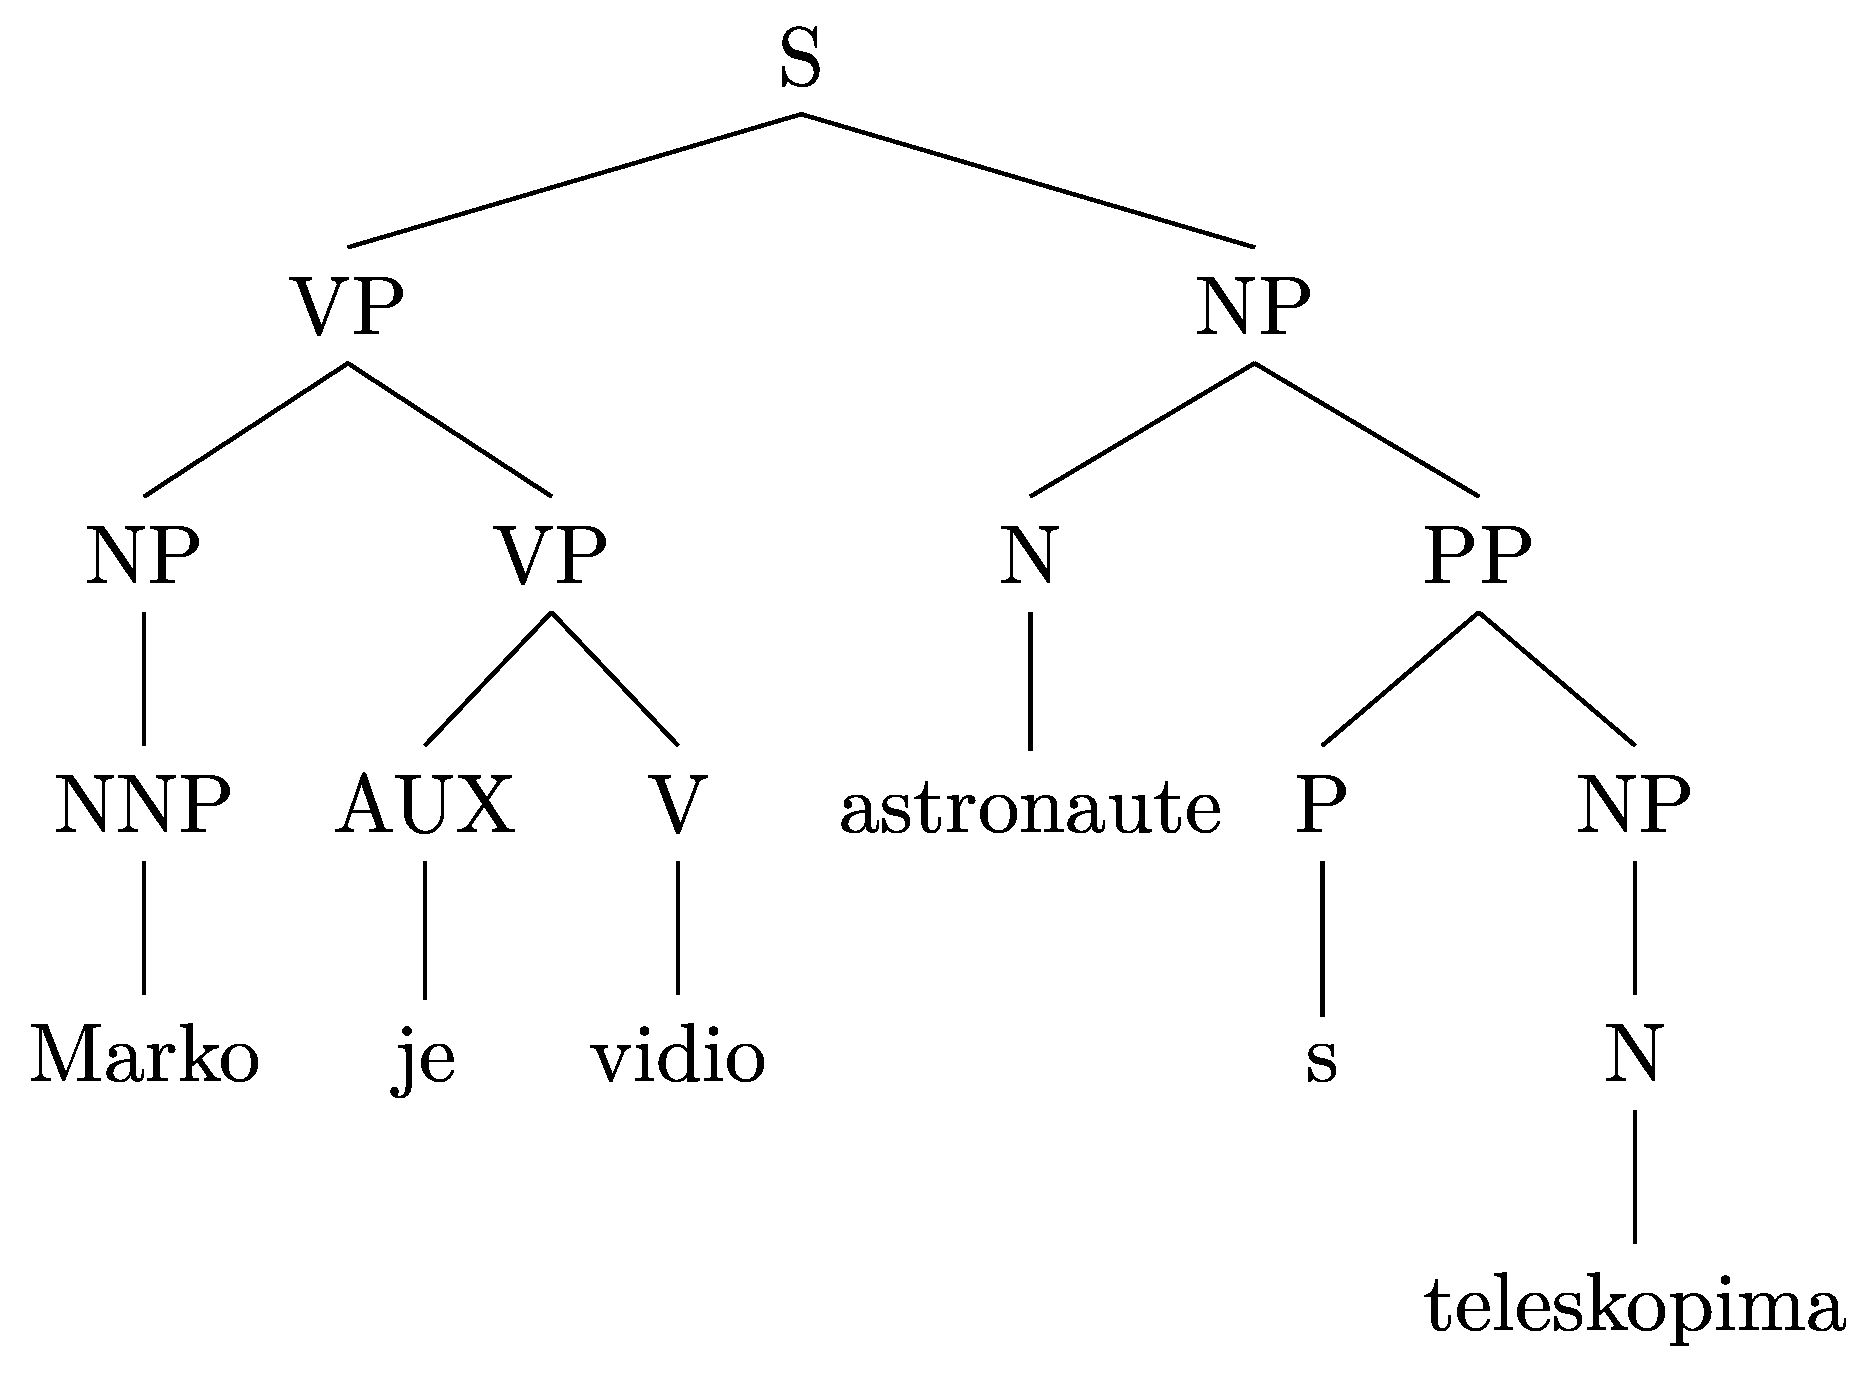

In [36]:
show_parse(hr_trees[0])